In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid  # To generate a unique ID for each file
from tqdm import tqdm
from scipy.sparse import block_diag
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import random
from scipy.linalg import svd, eigh
from joblib import Parallel, delayed
from typing import List, Tuple
import seaborn as sns
import math
from matplotlib.colors import LinearSegmentedColormap
import random

In [2]:
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 
               'chr20', 'chr21', 'chr22', 'chrX']
bins = {
    'chr1': 250,
    'chr2': 244,
    'chr3': 198,
    'chr4': 192,
    'chr5': 181,
    'chr6': 172,
    'chr7': 160,
    'chr8': 147,
    'chr9': 142,
    'chr10': 136,
    'chr11': 135,
    'chr12': 134,
    'chr13': 97,
    'chr14': 89,
    'chr15': 83,
    'chr16': 91,
    'chr17': 82,
    'chr18': 79,
    'chr19': 60,
    'chr20': 63,
    'chr21': 40,
    'chr22': 36,
    'chrX': 154
}



In [3]:
def visualize(matrix, cmap='viridis'):
    fig, ax = plt.subplots()
    cax = ax.imshow(matrix, cmap=cmap, interpolation='none')
    fig.colorbar(cax, label="Value")
    ax.set_title("Block-Diagonal Chromosome Matrix")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")
    # Turn off grid lines
    ax.grid(False)
    plt.show()

In [4]:
# FUNCTIONS FOR LOADING IN THE MATRICES FROM RAW TXT FILES.
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

def find_range(data, chr):
    range_pos1 = data[data['chr1'] == chr]["pos1"]
    range_pos2 = data[data['chr2'] == chr]["pos2"]
    
    max_pos1 = range_pos1.max()
    min_pos1 = range_pos1.min() 
    max_pos2 = range_pos2.max() 
    min_pos2 = range_pos2.min() 

    max_range = max(max_pos1, max_pos2) - min(min_pos1, min_pos2)
    return int(max_range / 1000000) + 1, min(min_pos1, min_pos2)


def load_txt_to_matrix(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1'] - min_position) / 1000000)
                pos2_index = int((row['pos2'] - min_position) / 1000000)
                if abs(pos1_index - pos2_index) >= 3:
                    X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

def load_txt_to_matrix_fix_size(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        chr_range = bins[chr]
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1']-min_position) / 1000000)
                pos2_index = int((row['pos2']-min_position) / 1000000)
                # if abs(pos1_index - pos2_index) >= 3:
                X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

In [5]:
# def pca_reconstruct_and_distance(matrix, n_components=50):
#     """
#     Performs PCA on the input matrix, reconstructs it using the specified number of components,
#     and computes the Frobenius distance between the original and reconstructed matrices.
    
#     Parameters:
#     - matrix (np.ndarray): Input 2D matrix of shape (2965, 2965).
#     - n_components (int): Number of principal components to retain.
    
#     Returns:
#     - float: Frobenius distance between the original and reconstructed matrix.
#     """
#     # Initialize PCA
#     pca = PCA(n_components=n_components, svd_solver='auto', random_state=42)
    
#     # Standardize the matrix
#     scaler = StandardScaler()
#     matrix_scaled = scaler.fit_transform(matrix)
    
#     X_reduced = pca.fit_transform(matrix_scaled)  # Shape: (2965, r)
    
#     # Compute XX^T
#     XXT = np.dot(X_reduced, X_reduced.T)  # Shape: (2965, 2965)
    
#     # Compute Frobenius distance between original and XXT
#     distance = np.linalg.norm(matrix_scaled - XXT, 'fro') ** 2
    
#     return distance

# def calculate_distance(matrix, n_components=50):
#     """
#     Calculates the Frobenius distance between the original matrix and its rank-r approximation.
    
#     Parameters:
#     - matrix (np.ndarray): Input 2D matrix of shape (2965, 2965).
#     - n_components (int): Number of principal components to retain.
    
#     Returns:
#     - float: Frobenius distance.
#     """
#     return pca_reconstruct_and_distance(matrix, n_components)


# # Function to calculate total distance for a list of matrices
# def calculate_total_distance(matrix_list, n_components=50, sample_num=20):
#     """
#     Samples a subset of matrices from the provided list, computes the Frobenius distance
#     for each, and returns the total sum of distances.
    
#     Parameters:
#     - matrix_list (list of np.ndarray): List containing matrices.
#     - n_components (int): Number of principal components to retain in PCA.
#     - sample_num (int): Number of matrices to sample from the list.
    
#     Returns:
#     - float: Total sum of Frobenius distances for the sampled matrices.
#     """
#     # Ensure sample_num does not exceed the number of available matrices
#     sample_num = min(sample_num, len(matrix_list))
    
#     # Sample a subset of matrices without replacement
#     sampled_matrices = random.sample(matrix_list, sample_num)

#     total_distance = 0.0
#     for matrix in sampled_matrices:
#         distance = pca_reconstruct_and_distance(matrix, n_components=n_components)
#         total_distance += distance
#     return total_distance

# def compute_total_distance_for_rank(rank, cell_lines, sample_num=20):
#     """
#     Computes the total Frobenius distance for a given PCA rank across all cell lines.

#     Parameters:
#     -----------
#     rank : int
#         Number of PCA components.
#     cell_lines : dict
#         Dictionary mapping cell line names to their respective matrix lists.
#     sample_num : int, default=20
#         Number of samples to draw from each cell line's matrix list.

#     Returns:
#     --------
#     total_distance_sum : float
#         Sum of Frobenius distances across all cell lines for the given rank.
#     """
#     total_distance_sum = 0.0
#     for matrix_list in cell_lines.values():
#         distance = calculate_total_distance(matrix_list, n_components=rank, sample_num=sample_num)
#         total_distance_sum += distance
#     return total_distance_sum

# def dimensionality_reduce(matrix: np.ndarray, n_components: int = 50, standardize: bool = True):
#     """
#     Reduces the dimensionality of the input matrix using PCA and computes M = X_reduced X_reduced^T.

#     Parameters:
#     -----------
#     matrix : np.ndarray
#         Input 2D matrix of shape (n_samples, n_features).
#     n_components : int, default=50
#         Number of principal components to keep.
#     standardize : bool, default=True
#         Whether to standardize the data before applying PCA.

#     Returns:
#     --------
#     M : np.ndarray
#         The matrix product of the reduced matrix and its transpose, shape (n_samples, n_samples).
#     pca : sklearn.decomposition.PCA
#         The fitted PCA model.
#     """
#     # Validate input dimensions
#     if matrix.ndim != 2:
#         raise ValueError(f"Input matrix must be 2D. Received {matrix.ndim}D.")
    
#     n_samples, n_features = matrix.shape

#     if n_components > n_features:
#         raise ValueError(f"n_components={n_components} cannot exceed the number of features={n_features}.")

#     # Standardize the data if required
#     if standardize:
#         scaler = StandardScaler()
#         matrix_scaled = scaler.fit_transform(matrix)
#     else:
#         matrix_scaled = matrix.copy()

#     # Initialize PCA
#     pca = PCA(n_components=n_components, svd_solver='auto', random_state=42)

#     # Fit PCA and transform the data
#     reduced_matrix = pca.fit_transform(matrix_scaled)  # Shape: (n_samples, n_components)

#     # Compute M = X_reduced X_reduced^T
#     M = np.dot(reduced_matrix, reduced_matrix.T)  # Shape: (n_samples, n_samples)

#     return M, pca


# def dimensionality_reduce_list_parallel(
#     matrices,
#     n_components: int = 50,
#     standardize: bool = True,
#     n_jobs: int = -1
# ):
   
#     def process_matrix(idx, matrix):
#         try:
#             reduced_matrix, pca_model = dimensionality_reduce(matrix, n_components, standardize)
#             return reduced_matrix, pca_model
#         except ValueError as ve:
#             print(f"ValueError for matrix {idx + 1}: {ve}")
#             return None, None
#         except Exception as e:
#             print(f"An error occurred while processing matrix {idx + 1}: {e}")
#             return None, None

#     results = Parallel(n_jobs=n_jobs)(
#         delayed(process_matrix)(idx, matrix) for idx, matrix in enumerate(matrices)
#     )

#     # Unpack results
#     reduced_matrices, pca_models = zip(*results)

#     # Filter out any failed reductions
#     reduced_matrices = [rm for rm in reduced_matrices if rm is not None]
#     pca_models = [pm for pm in pca_models if pm is not None]

#     return reduced_matrices

In [5]:
# UPDATED FUNCTION FOR TAKING THE APPROXIMATION OF MATRIX C
def approximate_matrix(C, r):
    """
    Approximates the matrix C using rank r approximation via eigendecomposition.

    Parameters:
    C (numpy.ndarray): The input symmetric matrix.
    r (int): The desired rank for the approximation.

    Returns:
    numpy.ndarray: The approximated matrix M of size same as C.
    """
    n = C.shape[0]
    C_full = np.zeros((n, n))
    # Fill upper triangle
    rows, cols = np.triu_indices(n)
    C_full[rows, cols] = C[rows, cols]
    # Fill lower triangle
    C_full = C_full + C_full.T - np.diag(np.diag(C_full))
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(C_full)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select the top r eigenvalues and eigenvectors
    eigenvalues_r = eigenvalues[:r]
    eigenvectors_r = eigenvectors[:, :r]
    
    # Handle negative eigenvalues (if any) by setting them to 0
    eigenvalues_r = np.maximum(eigenvalues_r, 0)
    
    # Construct X such that M = X*X^T
    X = eigenvectors_r @ np.diag(np.sqrt(eigenvalues_r))
    
    # Reconstruct the matrix M = X*X^T
    M = X @ X.T
    
    # Return only the upper triangular portion
    return np.triu(M)

In [6]:
def compute_error(C, r):
    # Ensure C is a float64 array
    C = C.astype(np.float64)
    M = approximate_matrix(C, r)
    diff = C - M
    fro_norm_sq = np.linalg.norm(diff, 'fro')**2
    return fro_norm_sq

In [7]:
def compute_total_error_parallel(matrix_list, r, n_jobs):
    """
    Computes the total Frobenius norm squared of (C - M) for all matrices in the list using parallel processing.

    Parameters:
    matrix_list (list of numpy.ndarray): List of matrices to process.
    r (int): The desired rank for the approximation.
    n_jobs (int): Number of parallel jobs.

    Returns:
    float: The total Frobenius norm squared error.
    """
    # Use joblib's Parallel to compute errors in parallel
    errors = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_error)(C, r) for C in matrix_list
    )
    total_error = np.sum(errors)
    return total_error

In [8]:
def plot_total_errors(total_errors, r_values):
    """
    Plots the total Frobenius norm squared errors for each cell type against the rank values.

    Parameters:
    total_errors (dict): Dictionary containing total errors for each cell type.
    r_values (list or array): List of rank values used for the approximation.
    """
    plt.figure(figsize=(12, 8))
    for cell_type in total_errors.keys():
        plt.plot(r_values, total_errors[cell_type], label=cell_type)
    
    plt.xlabel('Rank of Approximation (r)', fontsize=14)
    plt.ylabel('Total Frobenius Norm Squared of (C - M)', fontsize=14)
    plt.title('Total Error vs Rank of Approximation', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
GM12878_MATRICES_FIXED_SIZE = []
HAP1_MATRICES_FIXED_SIZE = []
Hela_MATRICES_FIXED_SIZE = []
K562_MATRICES_FIXED_SIZE = []

for file in tqdm(os.listdir("GM12878")):
    if file.endswith(".txt"):
        data = parse_file(f"GM12878/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            GM12878_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("HAP1")):
    if file.endswith(".txt"):
        data = parse_file(f"HAP1/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            HAP1_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("Hela")):
    if file.endswith(".txt"):
        data = parse_file(f"Hela/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            Hela_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("K562")):
    if file.endswith(".txt"):
        data = parse_file(f"K562/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            K562_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

100%|██████████| 48/48 [00:04<00:00, 10.14it/s]


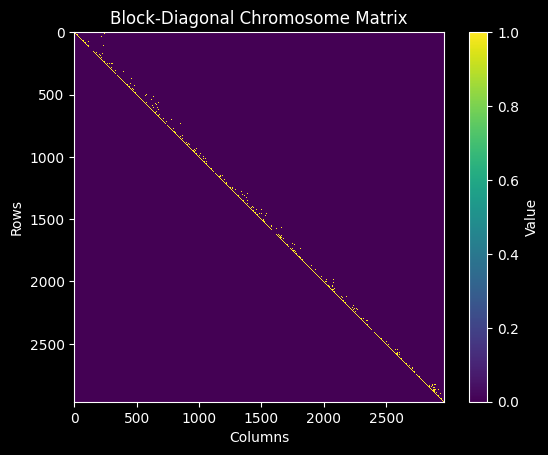

In [11]:
visualize(Hela_MATRICES_FIXED_SIZE[4])

In [12]:
sample_num = 20
random.seed(42)
# Step 1: Sample indices instead of matrices
Hela_indices = random.sample(range(len(Hela_MATRICES_FIXED_SIZE)), sample_num)
HAP1_indices = random.sample(range(len(HAP1_MATRICES_FIXED_SIZE)), sample_num)
GM12878_indices = random.sample(range(len(GM12878_MATRICES_FIXED_SIZE)), sample_num)
K562_indices = random.sample(range(len(K562_MATRICES_FIXED_SIZE)), sample_num)

# Step 2: Use sampled indices to create the samples
Hela_sample = [Hela_MATRICES_FIXED_SIZE[i] for i in Hela_indices]
HAP1_sample = [HAP1_MATRICES_FIXED_SIZE[i] for i in HAP1_indices]
GM12878_sample = [GM12878_MATRICES_FIXED_SIZE[i] for i in GM12878_indices]
K562_sample = [K562_MATRICES_FIXED_SIZE[i] for i in K562_indices]

print(Hela_indices)

[1309, 228, 51, 1518, 563, 501, 457, 285, 1508, 209, 1385, 1516, 1116, 178, 1209, 864, 65, 61, 191, 447]


In [13]:
GM12878_M = [approximate_matrix(C, 50) for C in tqdm(GM12878_sample)]

HAP1_M = [approximate_matrix(C, 50) for C in tqdm(HAP1_sample)]

Hela_M = [approximate_matrix(C, 50) for C in tqdm(Hela_sample)]

K562_M = [approximate_matrix(C, 50) for C in tqdm(K562_sample)]

100%|██████████| 20/20 [01:09<00:00,  3.45s/it]


In [14]:
import multiprocessing
# import logging
# def plot_rank_to_loss(cell_lines, ranks, sample_num=20):
#     """
#     Computes and plots the total sum of Frobenius distances across different PCA ranks
#     using parallel processing.
    
#     Parameters:
#     - cell_lines (dict): Dictionary mapping cell line names to their respective matrix lists.
#     - ranks (list): List of ranks to evaluate.
#     - sample_num (int): Number of matrices to sample from each cell line.
#     """
#     # Determine the number of available CPU cores (reserve one core)
#     num_cores = max(1, multiprocessing.cpu_count() - 1)
    
#     # Initialize progress bar
#     print("Computing total sum of Frobenius distances for each rank...")
    
#     # Parallel computation using Joblib
#     sum_distances = Parallel(n_jobs=num_cores)(
#         delayed(compute_total_distance_for_rank)(rank, cell_lines, sample_num)
#         for rank in tqdm(ranks, desc="Ranks")
#     )
    
#     # Filter out any None results due to errors
#     filtered_ranks = []
#     filtered_sum_distances = []
#     for rank, distance in zip(ranks, sum_distances):
#         if distance is not None:
#             filtered_ranks.append(rank)
#             filtered_sum_distances.append(distance)
#         else:
#             logging.warning(f"Skipping rank {rank} due to computation error.")
    
#     # Plotting the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(filtered_ranks, filtered_sum_distances, marker='o', linestyle='-', color='blue')
#     plt.title('Total Sum of Frobenius Distances vs PCA Rank', fontsize=14)
#     plt.xlabel('Rank (Number of PCA Components)', fontsize=12)
#     plt.ylabel('Total Sum of Frobenius Distances', fontsize=12)
#     plt.xticks(filtered_ranks)
#     plt.grid(True, linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()


In [15]:
# ranks = list(range(5, 201, 20))
# cell_lines = {
#     'GM12878': GM12878_sample,
#     'HAP1': HAP1_sample,
#     'Hela': Hela_sample,
#     'K562': K562_sample
# }
# plot_rank_to_loss(cell_lines=cell_lines, ranks=ranks, sample_num=20)

Using 10 CPU cores for parallel processing.


Processing ranks: 100%|██████████| 20/20 [24:24<00:00, 73.20s/it]


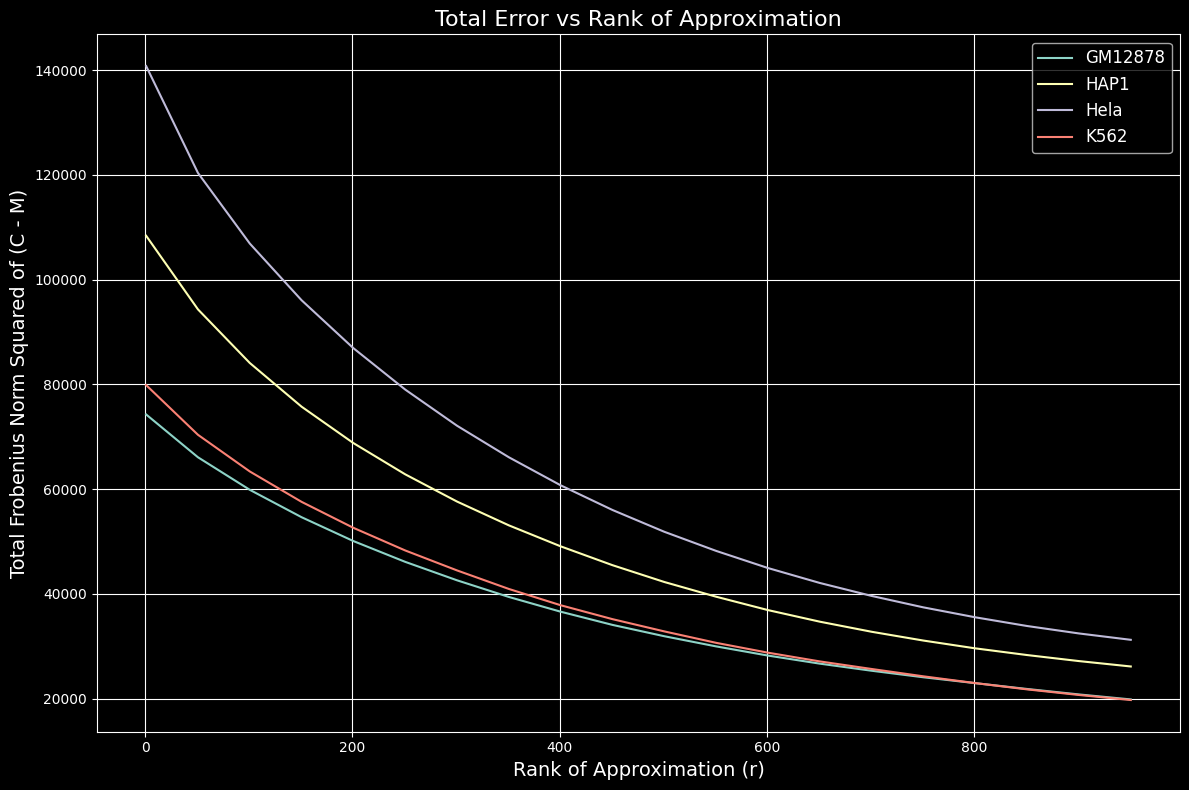

In [17]:
max_rank = 1000  # You can adjust this value as needed
r_values = range(1, max_rank + 1, 50)
total_errors = {
    'GM12878': [],
    'HAP1': [],
    'Hela': [],
    'K562': []
    }
cell_types = {
        'GM12878': GM12878_sample,
        'HAP1': HAP1_sample,
        'Hela': Hela_sample,
        'K562': K562_sample
    }
# Determine the number of available CPU cores
n_jobs = multiprocessing.cpu_count()
print(f"Using {n_jobs} CPU cores for parallel processing.")

# Iterate over each rank with a progress bar
for r in tqdm(r_values, desc="Processing ranks"):
    # Iterate over each cell type
    for cell_type, matrices in cell_types.items():
        # Compute the total error in parallel
        error = compute_total_error_parallel(matrices, r, n_jobs)
        total_errors[cell_type].append(error)

# Call the plotting function
plot_total_errors(total_errors, r_values)

In [18]:
def compute_eigenvalues(C):
    """
    Computes the eigenvalues of a symmetric matrix C.

    Parameters:
    C (numpy.ndarray): The input symmetric matrix.

    Returns:
    numpy.ndarray: Array of eigenvalues sorted in descending order.
    """
    n = C.shape[0]
    C_full = np.zeros((n, n))
    # Fill upper triangle
    rows, cols = np.triu_indices(n)
    C_full[rows, cols] = C[rows, cols]
    # Fill lower triangle
    C_full = C_full + C_full.T - np.diag(np.diag(C_full))
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, _ = np.linalg.eigh(C_full)
    
    # Sort the eigenvalues in descending order
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]
    
    return eigenvalues_sorted

def plot_eigenvalues(eigenvalues, title='Eigenvalues of Matrix C'):
    """
    Plots the eigenvalues of a matrix.

    Parameters:
    eigenvalues (numpy.ndarray): Array of eigenvalues.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', markersize=1)
    plt.xlabel('Index of Eigenvalue', fontsize=14)
    plt.ylabel('Eigenvalue', fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.show()

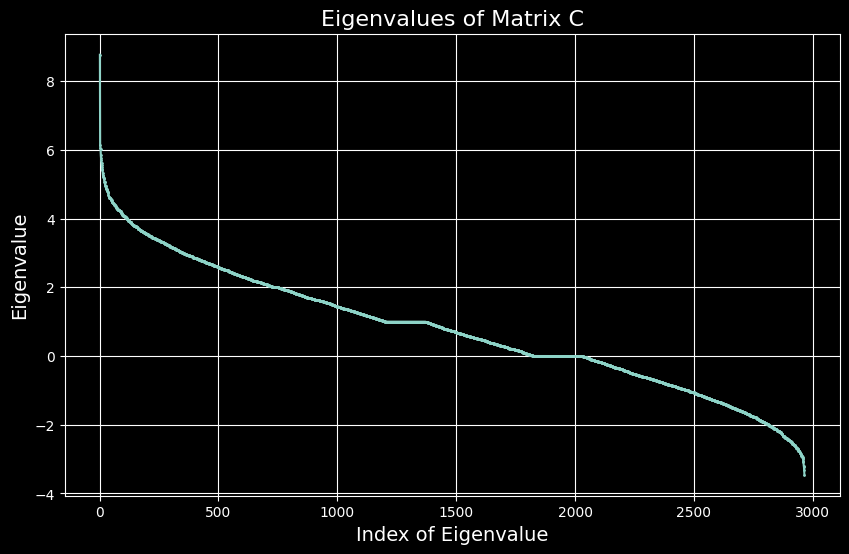

In [19]:
plot_eigenvalues(compute_eigenvalues(Hela_MATRICES_FIXED_SIZE[0]))

In [20]:
print(compute_eigenvalues(Hela_MATRICES_FIXED_SIZE[0])[:20])

[8.76715819 6.12675537 6.04427211 6.01700565 5.8410004  5.74899629
 5.70125576 5.61845658 5.56357257 5.49972656 5.44086778 5.4227063
 5.31401517 5.25456364 5.23441805 5.20410255 5.18835234 5.17702181
 5.15137345 5.07046254]


In [21]:
def compute_average_eigenvalues(matrix_list):
    eigenvalues_list = []
    for C in matrix_list:
        eigenvalues = compute_eigenvalues(C)
        eigenvalues_list.append(eigenvalues)
    
    eigenvalues_array = np.array(eigenvalues_list)
    average_eigenvalues = np.mean(eigenvalues_array, axis=0)
    
    return average_eigenvalues

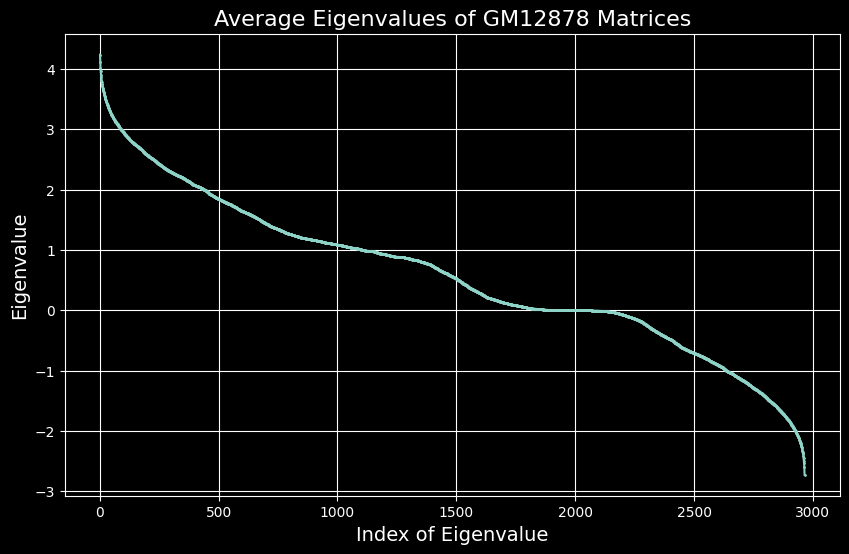

In [22]:
average_eigenvalues = compute_average_eigenvalues(GM12878_MATRICES_FIXED_SIZE)
plot_eigenvalues(average_eigenvalues, title='Average Eigenvalues of GM12878 Matrices')

In [23]:
sample = parse_file("K562/ml3_CGCTGTCT-CGTACGTA.txt")
sample_matrix_list = load_txt_to_matrix_fix_size(sample)

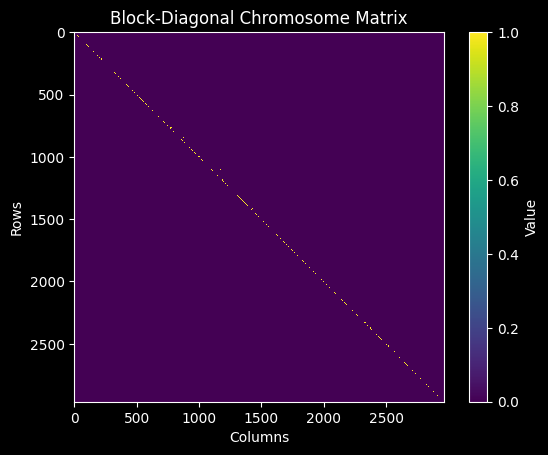

In [24]:
visualize(block_diag(sample_matrix_list).toarray())

In [25]:
def flatten_matrices(matrix_list):
    """
    Flattens a list of 2D matrices into a 2D array where each row is a flattened matrix.
    """
    return np.array([matrix.flatten() for matrix in matrix_list])

In [26]:
def plot_pca_with_cumulative_variance(
    X,
    labels,
    desired_variance=0.95,
    random_seed=None,
    figsize=(20, 8),
    palette='Set1',
    save_path=None
):
    """
    Performs PCA on the provided data and plots both the 2D PCA scatter plot
    and the cumulative variance explained plot.
    
    Parameters:
    -----------
    X : numpy.ndarray
        The feature matrix where each row corresponds to a sample and each column to a feature.
        
    labels : list or array-like
        The group labels corresponding to each sample in X.
        
    desired_variance : float, default=0.95
        The threshold for cumulative variance to determine the number of principal components.
        
    random_seed : int, optional
        Seed for the random number generator to ensure reproducibility.
        
    figsize : tuple, default=(20, 8)
        Size of the matplotlib figure.
        
    palette : str or list, default='Set1'
        Color palette for the scatter plot.
        
    save_path : str, optional
        If provided, the plot will be saved to the specified path.
        
    Returns:
    --------
    None
        Displays the plots. Optionally saves the figure if save_path is provided.
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # -------------------------------
    # Step 1: Standardize the Data
    # -------------------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # -------------------------------
    # Step 2: Perform PCA
    # -------------------------------
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Extract explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Determine the number of components needed to reach desired variance
    num_components = np.argmax(cumulative_variance >= desired_variance) + 1
    
    # -------------------------------
    # Step 3: Prepare DataFrame for Plotting
    # -------------------------------
    df_pca = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Group': labels
    })
    
    # -------------------------------
    # Step 4: Plotting
    # -------------------------------
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # --- Plot 1: 2D PCA Scatter Plot ---
    sns.scatterplot(
        ax=axes[0],
        data=df_pca,
        x='PC1',
        y='PC2',
        hue='Group',
        palette=palette,
        s=100,
        alpha=0.7
    )
    axes[0].set_title('PCA Scatter Plot', fontsize=16)
    axes[0].set_xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.1f}% Variance)', fontsize=14)
    axes[0].set_ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.1f}% Variance)', fontsize=14)
    axes[0].legend(title='Group', fontsize=12, title_fontsize=14)
    
    # --- Plot 2: Cumulative Variance Explained ---
    axes[1].plot(
        np.arange(1, len(cumulative_variance) + 1),
        cumulative_variance,
        marker='o',
        linestyle='-',
        color='b'
    )
    axes[1].axhline(y=desired_variance, color='r', linestyle='--', label=f'{desired_variance*100:.0f}% Variance')
    axes[1].axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} PCs')
    axes[1].annotate(
        f'{num_components} PCs',
        xy=(num_components, cumulative_variance[num_components - 1]),
        xytext=(num_components + 1, cumulative_variance[num_components - 1] - 0.1),
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=12
    )
    axes[1].set_title('Cumulative Variance Explained', fontsize=16)
    axes[1].set_xlabel('Number of Principal Components', fontsize=14)
    axes[1].set_ylabel('Cumulative Variance Explained', fontsize=14)
    axes[1].set_xticks(np.arange(1, len(cumulative_variance) + 1, step=1))
    axes[1].legend(fontsize=12, title_fontsize=14)
    axes[1].set_ylim(0, 1.05)
    
    plt.tight_layout()
    
    # Optionally save the figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    # Display the plot
    plt.show()
    
    # -------------------------------
    # Step 5: Print Explained Variance Details
    # -------------------------------
    print("Explained Variance by Each Principal Component:")
    for i, variance in enumerate(explained_variance_ratio, start=1):
        print(f"PC{i}: {variance*100:.2f}%")
    print(f"\nNumber of principal components to explain at least {desired_variance*100:.0f}% variance: {num_components}")

In [27]:
# Flatten the sampled matrices
HAP1_M_flat = flatten_matrices(HAP1_M)
Hela_M_flat = flatten_matrices(Hela_M)
GM12878_M_flat = flatten_matrices(GM12878_M)
K562_M_flat = flatten_matrices(K562_M)

# Combine all data into a single feature matrix
M = np.vstack((HAP1_M_flat, Hela_M_flat, GM12878_M_flat, K562_M_flat))

# Create labels for each group
labels = (
    ['HAP1'] * len(HAP1_M_flat) +
    ['Hela'] * len(Hela_M_flat) +
    ['GM12878'] * len(GM12878_M_flat) +
    ['K562'] * len(K562_M_flat)
)

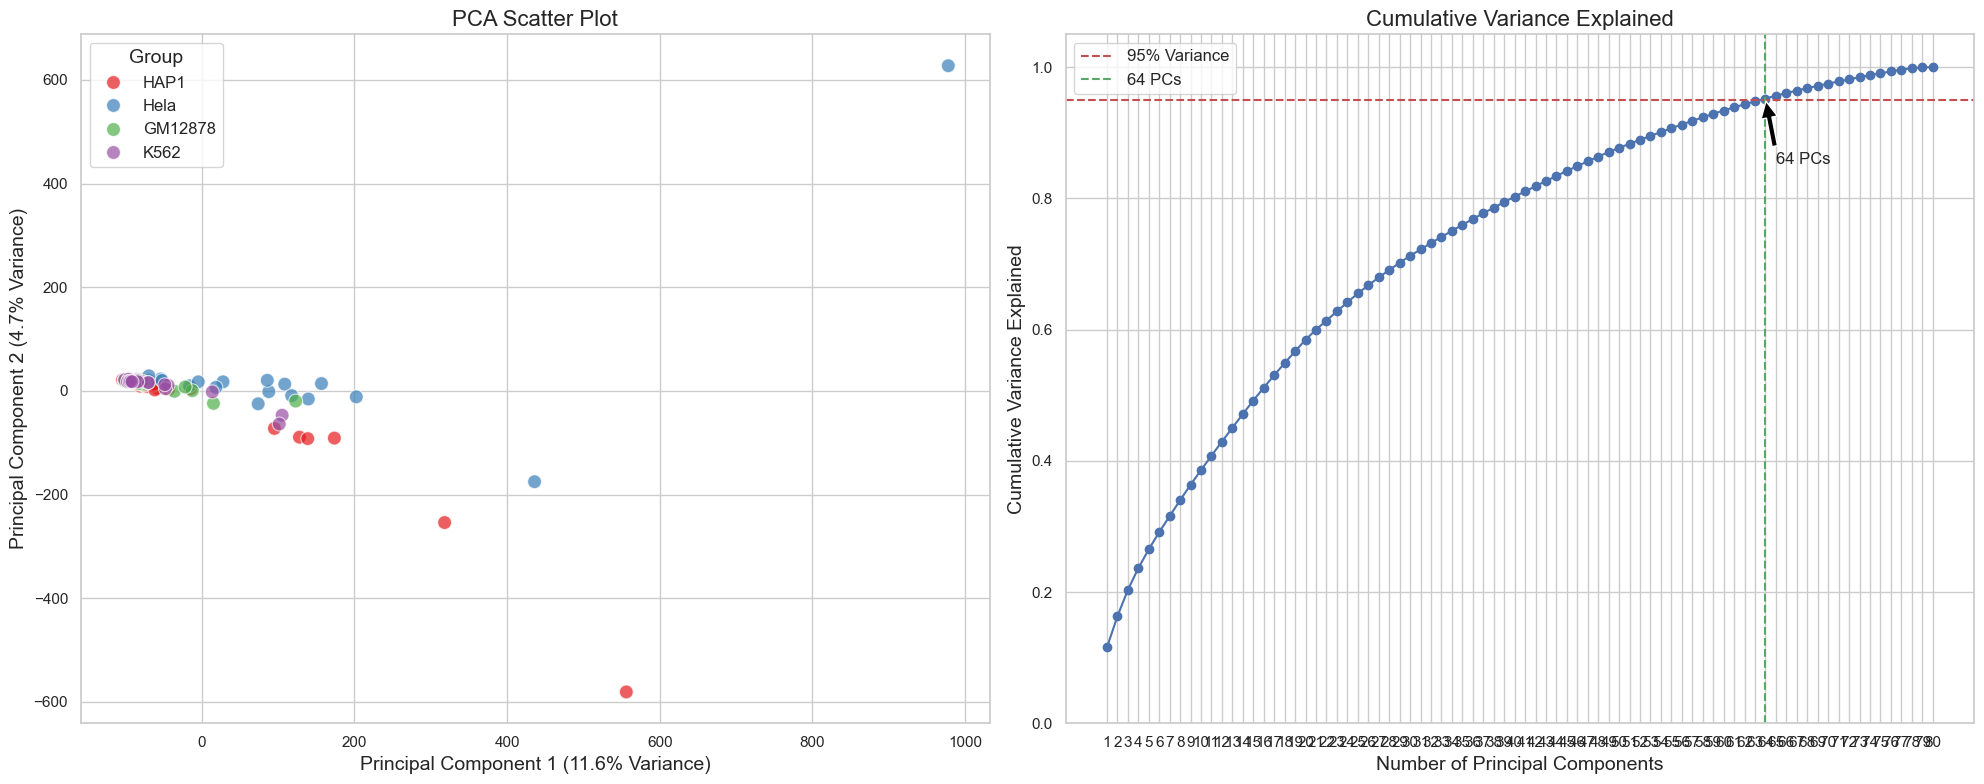

Explained Variance by Each Principal Component:
PC1: 11.56%
PC2: 4.74%
PC3: 4.02%
PC4: 3.31%
PC5: 2.89%
PC6: 2.60%
PC7: 2.45%
PC8: 2.42%
PC9: 2.36%
PC10: 2.23%
PC11: 2.21%
PC12: 2.13%
PC13: 2.12%
PC14: 2.10%
PC15: 2.05%
PC16: 1.97%
PC17: 1.90%
PC18: 1.84%
PC19: 1.81%
PC20: 1.76%
PC21: 1.53%
PC22: 1.40%
PC23: 1.39%
PC24: 1.38%
PC25: 1.36%
PC26: 1.23%
PC27: 1.21%
PC28: 1.12%
PC29: 1.10%
PC30: 1.06%
PC31: 0.98%
PC32: 0.97%
PC33: 0.94%
PC34: 0.91%
PC35: 0.91%
PC36: 0.89%
PC37: 0.88%
PC38: 0.85%
PC39: 0.85%
PC40: 0.82%
PC41: 0.80%
PC42: 0.80%
PC43: 0.79%
PC44: 0.77%
PC45: 0.76%
PC46: 0.74%
PC47: 0.72%
PC48: 0.72%
PC49: 0.69%
PC50: 0.64%
PC51: 0.62%
PC52: 0.61%
PC53: 0.60%
PC54: 0.59%
PC55: 0.58%
PC56: 0.57%
PC57: 0.55%
PC58: 0.55%
PC59: 0.53%
PC60: 0.51%
PC61: 0.49%
PC62: 0.46%
PC63: 0.45%
PC64: 0.44%
PC65: 0.42%
PC66: 0.41%
PC67: 0.38%
PC68: 0.36%
PC69: 0.35%
PC70: 0.34%
PC71: 0.33%
PC72: 0.32%
PC73: 0.32%
PC74: 0.31%
PC75: 0.30%
PC76: 0.28%
PC77: 0.26%
PC78: 0.22%
PC79: 0.16%
PC80: 0.00%


In [28]:
# Call the plotting function
plot_pca_with_cumulative_variance(
    X=M,
    labels=labels,
    desired_variance=0.95,        # Desired cumulative variance threshold
    random_seed=42,               # For reproducibility
    figsize=(20, 8),              # Figure size
    palette='Set1',               # Color palette for groups
    save_path=None     # Optional: Path to save the plots
)


In [29]:
scaler = StandardScaler()
M_scaled = scaler.fit_transform(M)

# Perform PCA
pca = PCA()
M_pca = pca.fit_transform(M_scaled)

# Create a DataFrame for PCA results
df_pca = pd.DataFrame({
    'PC1': M_pca[:, 0],
    'PC2': M_pca[:, 1],
    'Group': labels
})

In [30]:
from sklearn.metrics import pairwise_distances
def identify_outliers(df_pca, group_label='Hela', threshold=3):
    """
    Identifies outliers based on the distance from the group center in PCA space.

    Parameters:
    -----------
    df_pca : pd.DataFrame
        DataFrame containing PCA results with columns 'PC1', 'PC2', and 'Group'.
    
    group_label : str, default='Hela'
        The group for which outliers should be identified.
    
    threshold : float, default=3
        The Z-score threshold for outlier detection.

    Returns:
    --------
    outliers : pd.DataFrame
        DataFrame containing the outliers.
    """
    # Filter for the target group (e.g., Hela)
    group_data = df_pca[df_pca['Group'] == group_label]
    center = group_data[['PC1', 'PC2']].mean()  # Calculate the center of the group

    # Compute the distance of each point from the center
    distances = pairwise_distances(group_data[['PC1', 'PC2']], [center]).flatten()
    
    # Calculate Z-scores of the distances
    z_scores = (distances - distances.mean()) / distances.std()
    
    # Identify points where the Z-score is greater than the threshold
    outliers = group_data[z_scores > threshold].copy()
    outliers['Distance'] = distances[z_scores > threshold]
    outliers['Z-score'] = z_scores[z_scores > threshold]

    return outliers

In [31]:
outliers = identify_outliers(df_pca)
print(outliers)

           PC1         PC2 Group     Distance   Z-score
38  977.908553  627.253419  Hela  1061.028732  4.042553


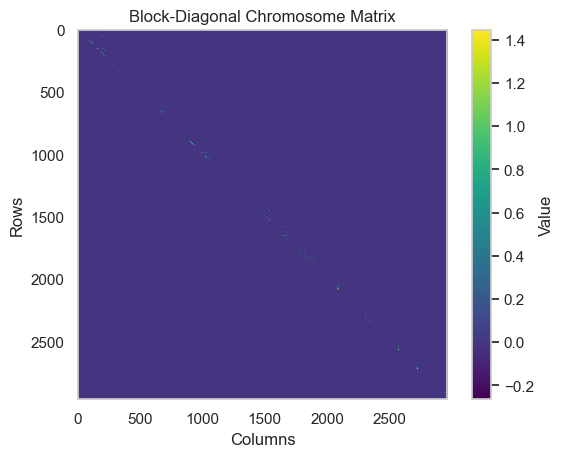

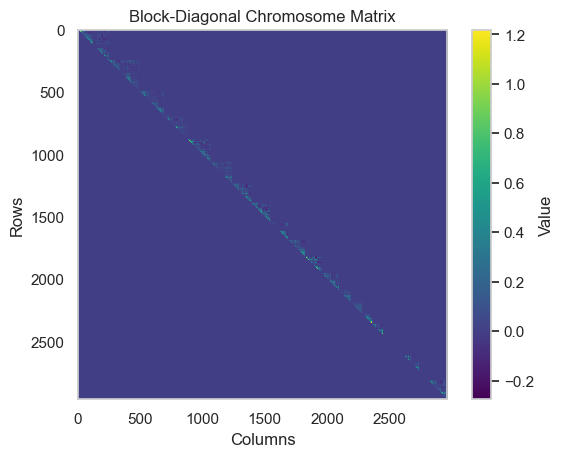

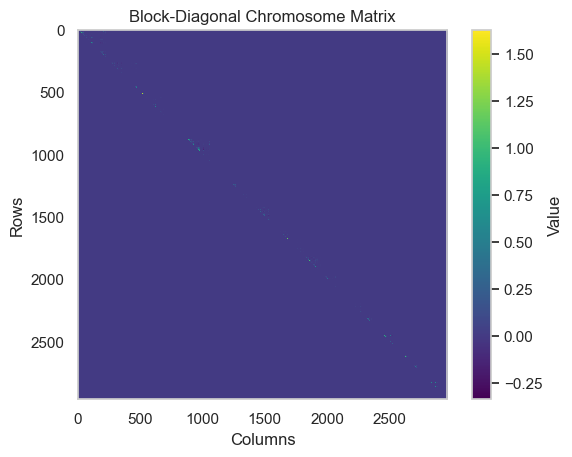

1673.4369312080958 13077.689780360784 1350.7702383559792


In [32]:
visualize(Hela_M[17])
visualize(Hela_M[18])
visualize(Hela_M[19])

print(Hela_M[17].sum() / 2965*2965, Hela_M[18].sum() / 2965*2965, Hela_M[19].sum() / 2965*2965)

In [33]:
# Flatten the sampled matrices
Hela_M_drop = Hela_M.pop(18)
Hela_M_flat_removed_outliers = flatten_matrices(Hela_M_drop)
HAP1_M_flat_new = flatten_matrices(HAP1_M.pop(18))
GM12878_M_flat_new = flatten_matrices(GM12878_M.pop(18))
K562_M_flat_new = flatten_matrices(K562_M.pop(18))


# Combine all data into a single feature matrix
M_new = np.vstack((HAP1_M_flat_new, Hela_M_flat_removed_outliers, GM12878_M_flat_new, K562_M_flat_new))

# Create labels for each group
labels_new = (
    ['HAP1'] * len(HAP1_M_flat_new) +
    ['Hela'] * len(Hela_M_flat_removed_outliers) +
    ['GM12878'] * len(GM12878_M_flat_new) +
    ['K562'] * len(K562_M_flat_new)
)

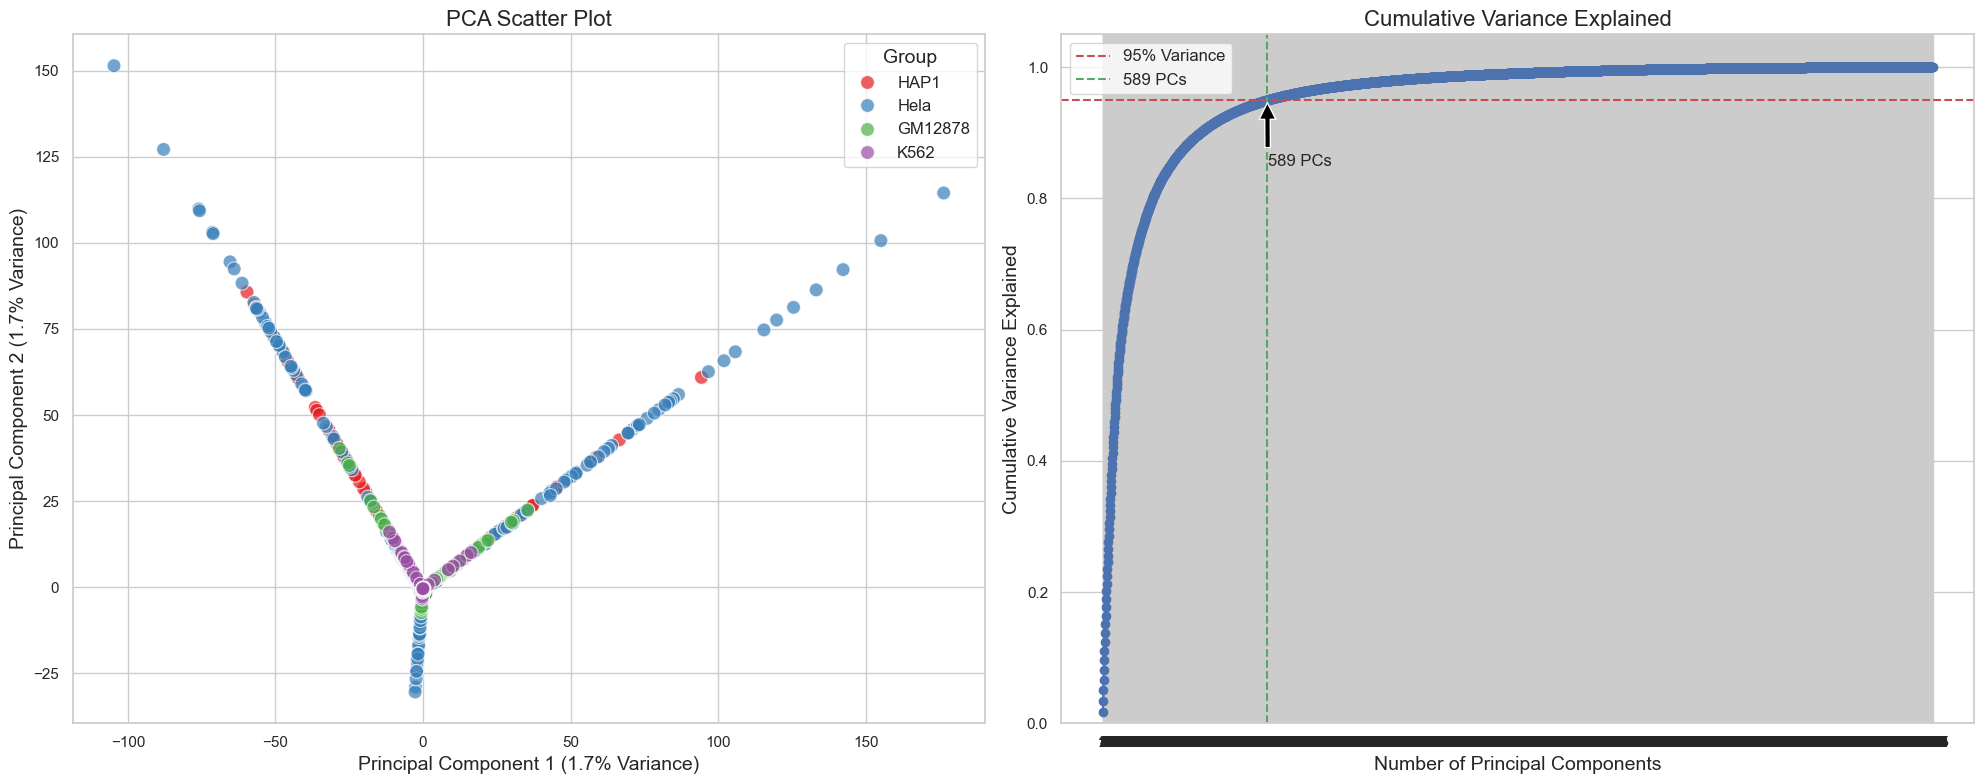

Explained Variance by Each Principal Component:
PC1: 1.72%
PC2: 1.71%
PC3: 1.64%
PC4: 1.57%
PC5: 1.53%
PC6: 1.47%
PC7: 1.45%
PC8: 1.36%
PC9: 1.34%
PC10: 1.30%
PC11: 1.30%
PC12: 1.29%
PC13: 1.25%
PC14: 1.21%
PC15: 1.16%
PC16: 1.11%
PC17: 1.05%
PC18: 1.05%
PC19: 1.05%
PC20: 1.02%
PC21: 1.01%
PC22: 1.00%
PC23: 0.99%
PC24: 0.96%
PC25: 0.94%
PC26: 0.93%
PC27: 0.93%
PC28: 0.92%
PC29: 0.91%
PC30: 0.90%
PC31: 0.89%
PC32: 0.88%
PC33: 0.87%
PC34: 0.87%
PC35: 0.85%
PC36: 0.84%
PC37: 0.83%
PC38: 0.81%
PC39: 0.79%
PC40: 0.78%
PC41: 0.76%
PC42: 0.73%
PC43: 0.71%
PC44: 0.70%
PC45: 0.68%
PC46: 0.67%
PC47: 0.60%
PC48: 0.59%
PC49: 0.59%
PC50: 0.58%
PC51: 0.58%
PC52: 0.57%
PC53: 0.57%
PC54: 0.56%
PC55: 0.50%
PC56: 0.50%
PC57: 0.49%
PC58: 0.49%
PC59: 0.48%
PC60: 0.47%
PC61: 0.44%
PC62: 0.43%
PC63: 0.39%
PC64: 0.39%
PC65: 0.38%
PC66: 0.38%
PC67: 0.37%
PC68: 0.36%
PC69: 0.36%
PC70: 0.34%
PC71: 0.34%
PC72: 0.33%
PC73: 0.33%
PC74: 0.32%
PC75: 0.31%
PC76: 0.30%
PC77: 0.30%
PC78: 0.30%
PC79: 0.29%
PC80: 0.28%
P

In [34]:
# Call the plotting function
plot_pca_with_cumulative_variance(
    X=M_new,
    labels=labels_new,
    desired_variance=0.95,        # Desired cumulative variance threshold
    random_seed=42,               # For reproducibility
    figsize=(20, 8),              # Figure size
    palette='Set1',               # Color palette for groups
    save_path=None     # Optional: Path to save the plots
)


In [35]:
def map_chromosomes_to_indices(bins):
    chr_indices = {}
    current_start = 0
    for chr_name, bin_count in bins.items():
        start = current_start
        end = current_start + bin_count
        chr_indices[chr_name] = (start, end)
        current_start = end
    return chr_indices

def perform_multi_pc_analysis(X, n_components=5):
    """
    Perform PCA with multiple components and return combined loadings.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Input data matrix
    n_components : int
        Number of PCs to compute
        
    Returns:
    --------
    combined_loadings : numpy.ndarray
        Combined loadings from all PCs
    explained_variance_ratio : numpy.ndarray
        Explained variance ratio for each PC
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Get loadings for all components
    loadings = pca.components_  # Shape: (n_components, 2965*2965)
    
    # Calculate weighted sum of loadings based on explained variance ratio
    weighted_loadings = np.zeros_like(loadings[0])
    for i in range(n_components):
        weighted_loadings += np.abs(loadings[i]) * pca.explained_variance_ratio_[i]
    
    return weighted_loadings, pca.explained_variance_ratio_

def create_chromosome_heatmaps(loadings_matrix, chromosome_bins, chr_indices, explained_variance_ratio,
                             cmap='viridis', vmin=None, vmax=None):
    """
    Creates heatmaps for each chromosome based on combined PCA loadings.
    """
    num_chromosomes = len(chromosome_bins)
    grid_size = math.ceil(math.sqrt(num_chromosomes))
    
    fig = plt.figure(figsize=(20, 22))  # Increased height for variance plot
    
    # Create subplot for explained variance
    gs = plt.GridSpec(grid_size + 1, grid_size, height_ratios=[1] * grid_size + [0.3])
    
    # Plot explained variance
    ax_var = plt.subplot(gs[-1, :])
    ax_var.bar(range(1, len(explained_variance_ratio) + 1), 
               explained_variance_ratio * 100,
               alpha=0.8)
    ax_var.set_xlabel('Principal Component')
    ax_var.set_ylabel('Explained Variance (%)')
    ax_var.set_title('Explained Variance Ratio by Principal Component')
    
    # Create heatmap subplots
    axs = []
    for i in range(grid_size):
        for j in range(grid_size):
            ax = plt.subplot(gs[i, j])
            axs.append(ax)
    
    axs = np.array(axs)
    
    # Create heatmaps
    for i, (chr_name, bins_count) in enumerate(chromosome_bins.items()):
        start, end = chr_indices[chr_name]
        
        # Extract submatrix for the chromosome
        chr_loadings = loadings_matrix[start:end, start:end]
        
        # Calculate sum of loadings over area for this chromosome
        total_loading = np.sum(chr_loadings)
        avg_loading = total_loading / (bins_count * bins_count)
        
        # Plot heatmap
        sns.heatmap(
            chr_loadings,
            ax=axs[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            xticklabels=False,
            yticklabels=False
        )
        
        # Set title with
        # loading information
        axs[i].set_title(f'{chr_name}\nAvg Loading: {avg_loading:.2e}', fontsize=10)
        axs[i].axis('off')
    
    # Remove unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=vmin if vmin is not None else np.min(loadings_matrix),
                        vmax=vmax if vmax is not None else np.max(loadings_matrix))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Combined PCA Loading', fontsize=12)
    
    plt.suptitle(f'Chromosome-wise PCA Loadings\n(Combined from {len(explained_variance_ratio)} PCs)',
                fontsize=14, y=0.95)
    plt.tight_layout(rect=[0, 0, 0.9, 0.93])
    
    return fig

def analyze_and_plot_loadings(X, bins, n_components=5, vmin=0, vmax=0.015):
    """
    Perform complete analysis and visualization of PCA loadings.
    """
    # Get chromosome indices
    chr_indices = map_chromosomes_to_indices(bins)
    
    # Perform PCA and get combined loadings
    weighted_loadings, explained_variance_ratio = perform_multi_pc_analysis(X, n_components)
    
    # Reshape loadings into a 2D matrix
    loadings_matrix = weighted_loadings.reshape((2965, 2965))
    
    # Create and display heatmaps
    fig = create_chromosome_heatmaps(
        loadings_matrix=loadings_matrix,
        chromosome_bins=bins,
        chr_indices=chr_indices,
        explained_variance_ratio=explained_variance_ratio,
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    
    return fig

/var/folders/l4/68_gb6bj02x8w61k1xskbnsw0000gn/T/ipykernel_46362/924263923.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


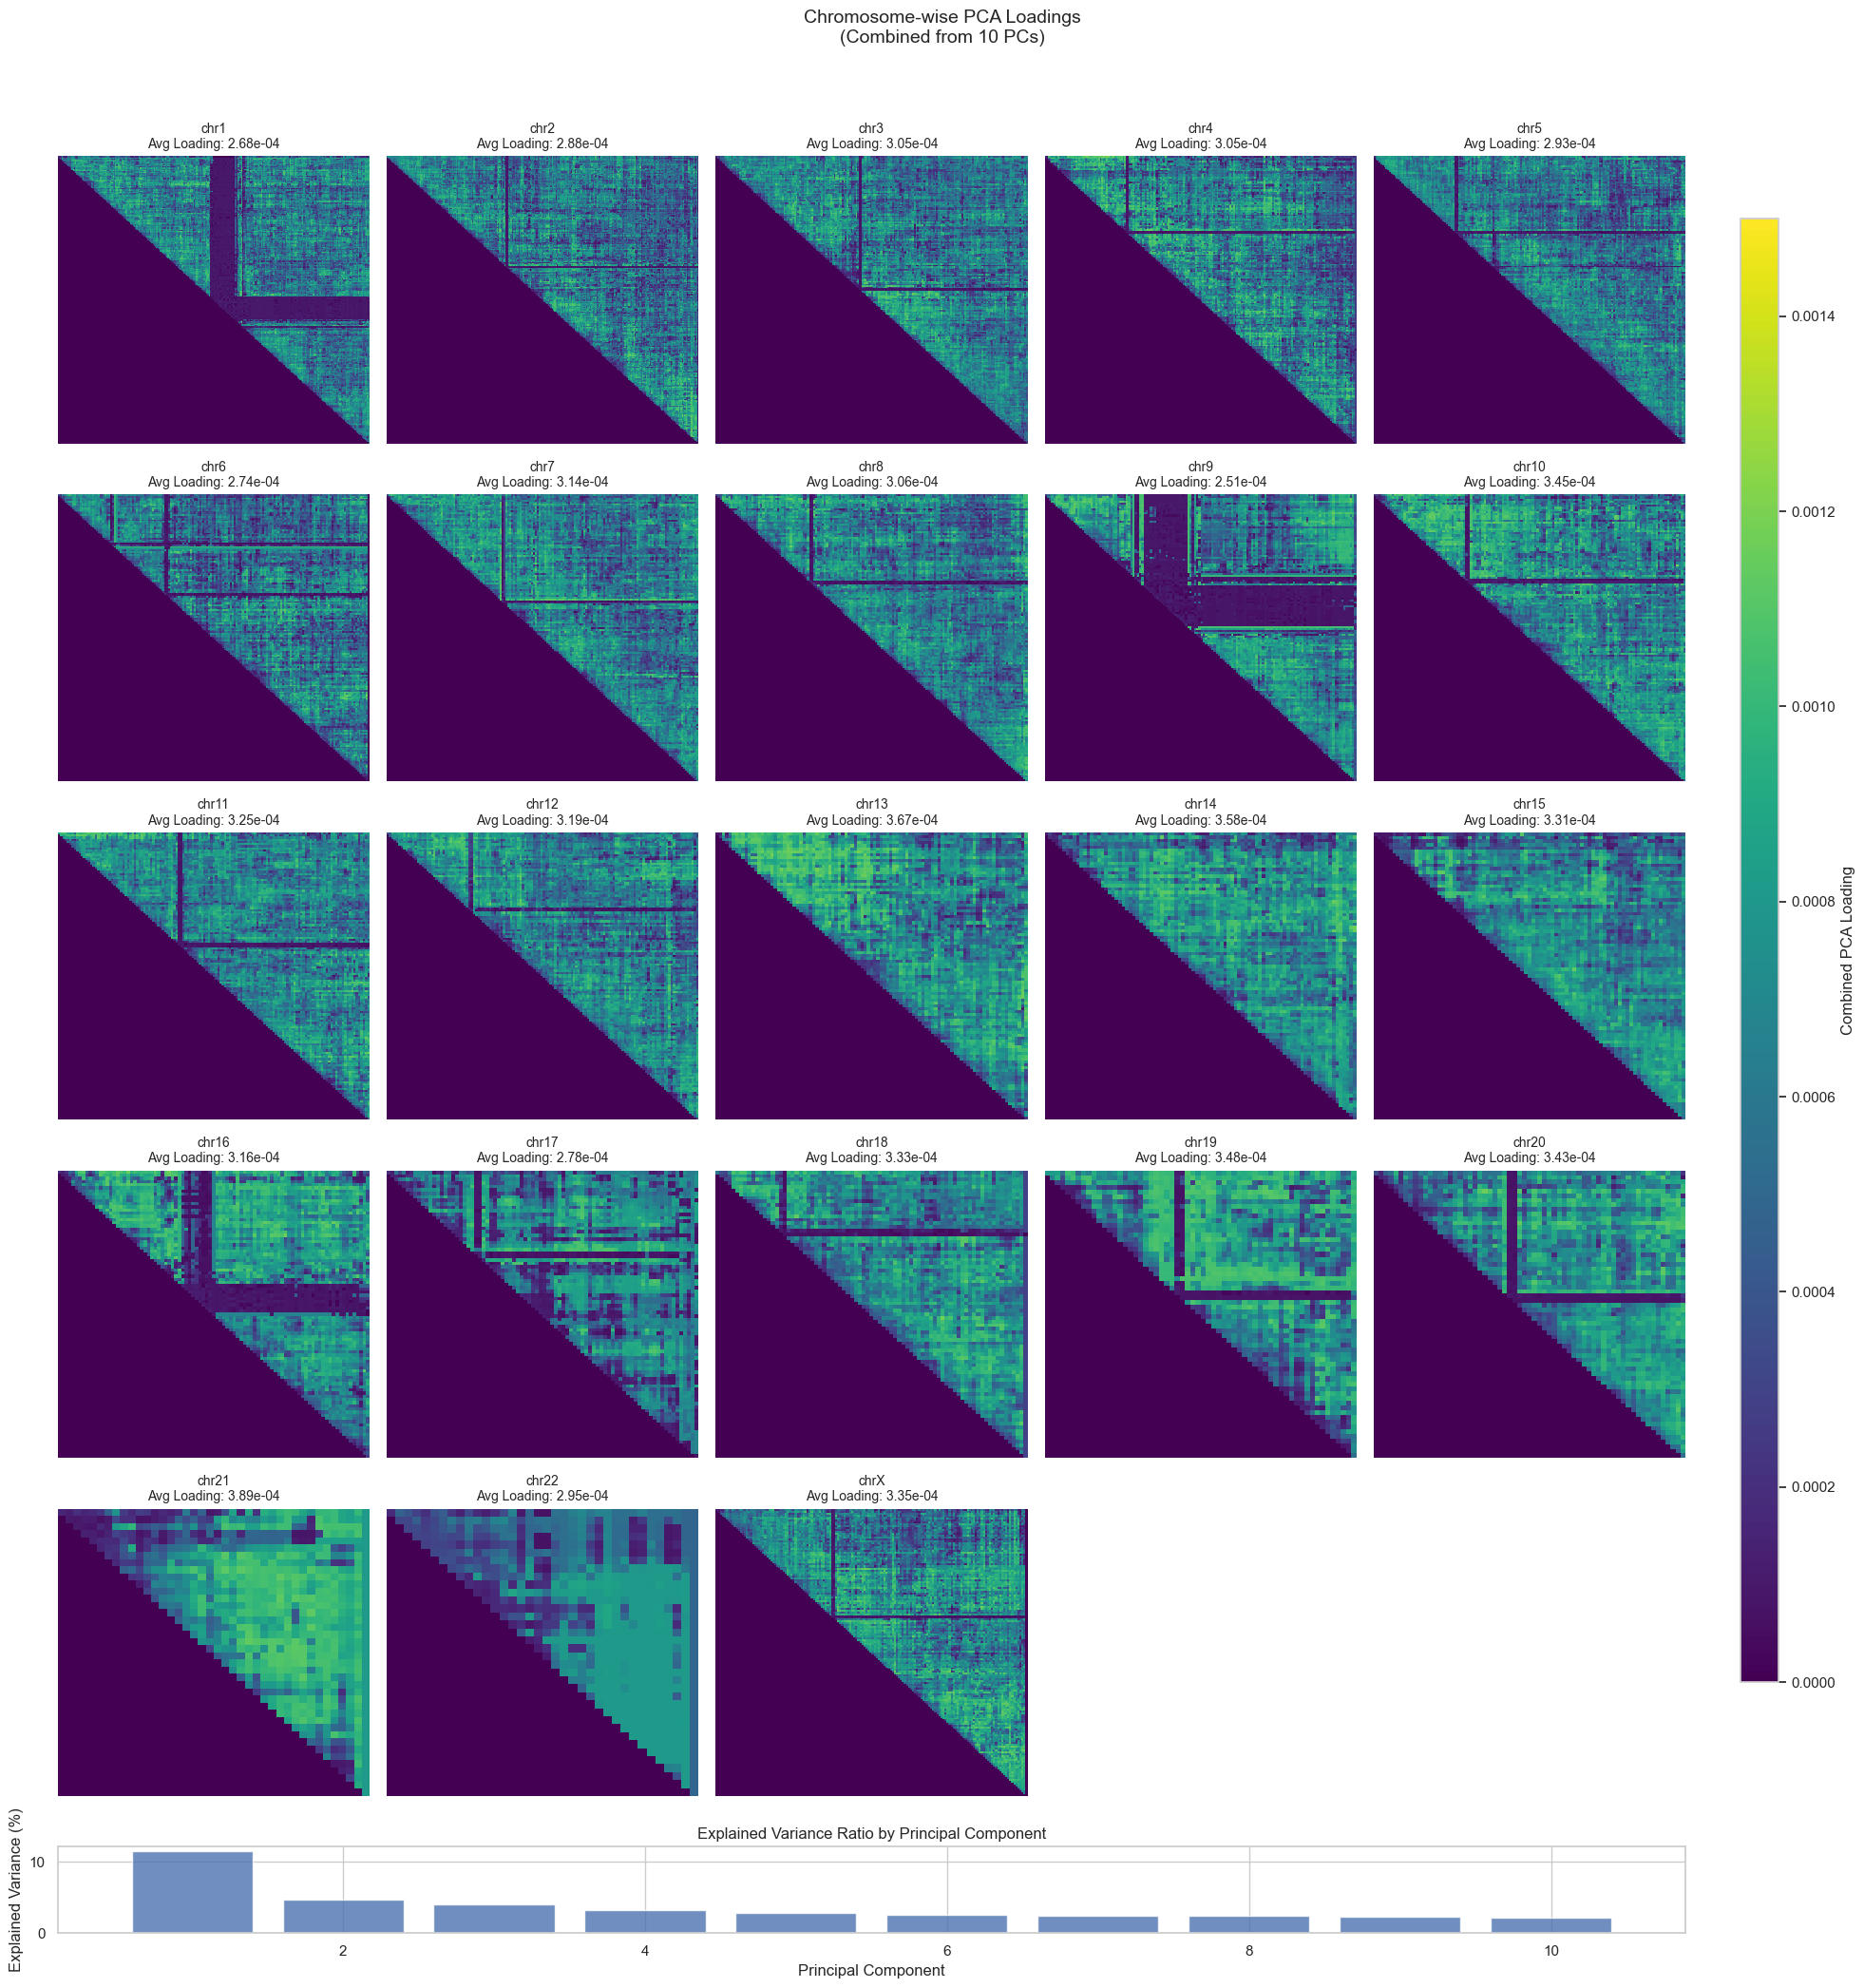

In [36]:
# For a single analysis:
fig = analyze_and_plot_loadings(M, bins, n_components=10, vmin=0, vmax=0.0015)
plt.show()

In [61]:
C = np.array([[4, 1, 1],
              [1, 3, 0],
              [1, 0, 2]])

# Step 2: Manually center the data by subtracting the mean of each feature (column)
C_mean = np.mean(C, axis=0)
C_centered = C - C_mean

print("\nMean of C (per column):\n", C_mean)
print("\nCentered C:\n", C_centered)

# Step 3: Compute the rank-2 approximation via SVD on centered data

# Perform SVD on the centered matrix
U_SVD, S_SVD, Vt_SVD = np.linalg.svd(C_centered, full_matrices=False)

print("\nSingular Values from SVD:\n", S_SVD)
print("\nMatrix U_SVD (Left singular vectors):\n", U_SVD)
print("\nMatrix Vt_SVD (Right singular vectors):\n", Vt_SVD)

# Select the top 2 singular values and corresponding vectors
k = 2
U_k_SVD = U_SVD[:, :k]
S_k_SVD = np.diag(S_SVD[:k])
Vt_k_SVD = Vt_SVD[:k, :]

print("\nMatrix U_k_SVD (First 2 Left Singular Vectors):\n", U_k_SVD)
print("\nMatrix S_k_SVD (Top 2 Singular Values):\n", S_k_SVD)

# Reconstruct the rank-2 approximation
C_2_SVD_centered = U_k_SVD @ S_k_SVD @ Vt_k_SVD

# Add the mean back to obtain the final approximation
C_2_SVD = C_2_SVD_centered + C_mean

print("\nRank-2 Approximation C_2 via SVD:\n", C_2_SVD)




Mean of C (per column):
 [2.         1.33333333 1.        ]

Centered C:
 [[ 2.         -0.33333333  0.        ]
 [-1.          1.66666667 -1.        ]
 [-1.         -1.33333333  1.        ]]

Singular Values from SVD:
 [2.68612182e+00 2.33482681e+00 7.17272894e-17]

Matrix U_SVD (Left singular vectors):
 [[-0.51994159 -0.6295454   0.57735027]
 [ 0.8051731  -0.13550992  0.57735027]
 [-0.28523152  0.76505532  0.57735027]]

Matrix Vt_SVD (Right singular vectors):
 [[-0.5806977   0.70569313 -0.40594012]
 [-0.80889777 -0.44374819  0.38570966]
 [ 0.09205746  0.55234477  0.82851716]]

Matrix U_k_SVD (First 2 Left Singular Vectors):
 [[-0.51994159 -0.6295454 ]
 [ 0.8051731  -0.13550992]
 [-0.28523152  0.76505532]]

Matrix S_k_SVD (Top 2 Singular Values):
 [[2.68612182 0.        ]
 [0.         2.33482681]]

Rank-2 Approximation C_2 via SVD:
 [[4. 1. 1.]
 [1. 3. 0.]
 [1. 0. 2.]]


In [59]:
C_mean = np.mean(C, axis=0)
C_centered = C - C_mean

# Initialize PCA with n_components=2
pca = PCA(n_components=2, svd_solver='full', whiten=False)

# Fit PCA on the centered data
pca.fit(C_centered)

# Transform the data to the principal component space
C_pca_transformed = pca.transform(C_centered)

# Reconstruct the data from the principal components
C_2_PCA_centered = pca.inverse_transform(C_pca_transformed)

# Add the mean back to obtain the final approximation
C_2_PCA = C_2_PCA_centered + C_mean

print("\nRank-2 Approximation C_2 via PCA:\n", C_2_PCA)


Rank-2 Approximation C_2 via PCA:
 [[4. 1. 1.]
 [1. 3. 0.]
 [1. 0. 2.]]
